<a href="https://colab.research.google.com/github/Schwarzam/NN-SPLUS/blob/master/EfficientNET_Test_S_E_IRG%20with%20k-fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
pip install schzz

     |████████████████████████████████| 204kB 4.6MB/s 


In [2]:
pip install keras_applications

     |████████████████████████████████| 51kB 2.5MB/s 


In [3]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from skimage.io import imread
from sklearn.model_selection import train_test_split
from schzz import RealTime, Submit
from sklearn.metrics import classification_report, confusion_matrix

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, GlobalAveragePooling2D, BatchNormalization

Download Images

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/trainsets/ALLpngsDifBands.zip \
    -O /tmp/Galaxies.zip

--2020-08-23 21:36:50--  https://storage.googleapis.com/trainsets/ALLpngsDifBands.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 848688951 (809M) [application/zip]
Saving to: ‘/tmp/Galaxies.zip’

/tmp/Galaxies.zip   100%[===================>] 809.37M  92.9MB/s    in 13s     

2020-08-23 21:37:04 (63.2 MB/s) - ‘/tmp/Galaxies.zip’ saved [848688951/848688951]



Extract Imgs, load csv

In [5]:
local_zip = '/tmp/Galaxies.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

base_dir = '/tmp/Galaxies/'

IRG_dir = '/tmp/Galaxies/IRG/'
IGU_dir = '/tmp/Galaxies/IGU/'
ZRG_dir = '/tmp/Galaxies/ZRG/'
R660G_dir = '/tmp/Galaxies/R660G/'

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/Schwarzam/NN-SPLUS/master/ImgsCSV.csv')

In [7]:
arr = []

for key, value in df.iterrows():
  if value.SPIRAL == 1:
    arr.append(0)
  if value.ELLIPTICAL == 1:
    arr.append(1)
  if value.UNCERTAIN == 1:
    arr.append(2)

df = df.assign(Class = arr)

In [8]:
df['IRG'] = df['ID'].map(lambda ID: os.path.join(IRG_dir, f'{ID}.png'))
df['IGU'] = df['ID'].map(lambda ID: os.path.join(IGU_dir, f'{ID}.png'))
df['ZRG'] = df['ID'].map(lambda ID: os.path.join(ZRG_dir, f'{ID}.png'))
df['R660G'] = df['ID'].map(lambda ID: os.path.join(R660G_dir, f'{ID}.png'))

in_channel = 3
img_rows, img_cols = 128, 128
num_classes = 3 # number of appliances

input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

batch_size = 10
labels = df['Class'].values
arr_labels = df['Class'].values

In [9]:
def read_spectograms(file_paths, img_rows, img_cols, channels):
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255.0 #np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [10]:
targets = df[(df['SPIRAL'] == 1) | (df['ELLIPTICAL'] == 1)]
targets['Class'].value_counts()

0    2615
1    1206
Name: Class, dtype: int64

In [11]:
np.random.seed(10)

remove_n = 1300
ellipt = targets[targets['Class'] == 0]
drop_indices = np.random.choice(ellipt.index, remove_n, replace=False)
targets = targets.drop(drop_indices)



labels = targets['Class'].values
arr_labels = targets['Class'].values

targets['Class'].value_counts()

0    1315
1    1206
Name: Class, dtype: int64

In [12]:
x_train_IRG = read_spectograms(targets['IRG'].values, img_rows, img_cols, in_channel)
x_train_IGU = read_spectograms(targets['IGU'].values, img_rows, img_cols, in_channel)
x_train_ZRG = read_spectograms(targets['ZRG'].values, img_rows, img_cols, in_channel)
x_train_R660G = read_spectograms(targets['R660G'].values, img_rows, img_cols, in_channel)

[]

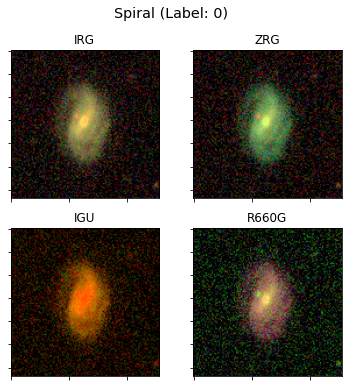

In [13]:
appliances = [
    
    'Spiral',
    'Elliptical',
    
]

rn_appliance = np.random.choice(targets['Class'].values)
rn_appliance = 2400
rn_label = targets['Class'].values[rn_appliance]
rn_IRG = x_train_IRG[rn_appliance]
rn_IGU = x_train_IGU[rn_appliance]
rn_ZRG = x_train_ZRG[rn_appliance]
rn_R660G = x_train_R660G[rn_appliance]

fig, ax = plt.subplots(2, 2, figsize=((6,6)))
plt.suptitle(f"{appliances[rn_label]} (Label: {rn_label})", fontsize="x-large")

curr_img = None

curr_img = np.reshape(rn_IRG, (img_rows, img_cols, in_channel))

ax[0, 0].imshow(curr_img, cmap='gray')
ax[0, 0].set_title("IRG")
ax[0, 0].plot()

ax[0, 0].set_yticklabels([])
ax[0, 0].set_xticklabels([])

curr_img = np.reshape(rn_ZRG, (img_rows, img_cols, in_channel))

ax[0, 1].imshow(curr_img, cmap='gray')
ax[0, 1].set_title("ZRG")
ax[0, 1].plot()

ax[0, 1].set_yticklabels([])
ax[0, 1].set_xticklabels([])

curr_img = np.reshape(rn_IGU, (img_rows, img_cols, in_channel))

ax[1, 0].imshow(curr_img, cmap='gray')
ax[1, 0].set_title("IGU")
ax[1, 0].plot()

ax[1, 0].set_yticklabels([])
ax[1, 0].set_xticklabels([])

curr_img = np.reshape(rn_R660G, (img_rows, img_cols, in_channel))

ax[1, 1].imshow(curr_img, cmap='gray')
ax[1, 1].set_title("R660G")
ax[1, 1].plot()

ax[1, 1].set_yticklabels([])
ax[1, 1].set_xticklabels([])

In [14]:
x_train_comp = np.stack((x_train_IRG, x_train_IGU), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, arr_labels, test_size = 0.3, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)
val_labels = y_val

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)


# take them apart
train_IRG = x_train[:,:,:,:,0]
test_IRG = x_test[:,:,:,:,0]

train_IGU = x_train[:,:,:,:,1]
test_IGU = x_test[:,:,:,:,1]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)

test_IRG = x_test[:,:,:,:,0]
val_IRG = x_val[:,:,:,:,0]

test_IGU = x_test[:,:,:,:,1]
val_IGU = x_val[:,:,:,:,1]

del x_train_IRG
del x_train_IGU

In [15]:
x_train_comp = np.stack((x_train_ZRG, x_train_R660G), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, arr_labels, test_size = 0.3, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)
val_labels = y_val

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)

# take them apart
train_ZRG = x_train[:,:,:,:,0]
test_ZRG = x_test[:,:,:,:,0]

train_R660G = x_train[:,:,:,:,1]
test_R660G = x_test[:,:,:,:,1]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)

test_ZRG = x_test[:,:,:,:,0]
val_ZRG = x_val[:,:,:,:,0]

test_R660G = x_test[:,:,:,:,1]
val_R660G = x_val[:,:,:,:,1]

del x_train_ZRG
del x_train_R660G

CREATING MODEL

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [17]:
import sys
sys.path.append('/content/drive/My Drive/Morfo-master/utils')

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
import efficientnet.tfkeras as efn

model_efn = efn.EfficientNetB7(weights='imagenet', include_top=False)

258441216/258434480 [==============================] - 8s 0us/step


In [19]:
import efficientnet.tfkeras as efn

def get_new_model():
  model_efn = efn.EfficientNetB7(weights='imagenet', include_top=False)
  IRG_input = Input(shape=input_shape)
  IRG_model = model_efn(IRG_input)
  IRG_model = Flatten()(IRG_model)

  # IGU_input = Input(shape=input_shape)
  # IGU_model = create_convolution_layers(IGU_input)
  # IGU_model = Flatten()(IGU_model)

  # ZRG_input = Input(shape=input_shape)
  # ZRG_model = create_convolution_layers(ZRG_input)
  # ZRG_model = Flatten()(ZRG_model)

  # R660G_input = Input(shape=input_shape)
  # R660G_model = create_convolution_layers(R660G_input)
  # R660G_model = Flatten()(R660G_model)

  # conv = concatenate([IRG_model, IGU_model, ZRG_model, R660G_model])
  dense = Dense(4096)(IRG_model)
  dense = Dropout(0.4)(dense)
  dense = Dense(1024)(IRG_model)
  dense = Dropout(0.3)(dense)
  dense = Dense(512)(IRG_model)
  dense = Dropout(0.3)(dense)
  dense = Dense(256)(dense)

  output = Dense(1, activation='sigmoid')(dense)

  model = Model(inputs=IRG_input, outputs=[output])

  return model

DATA ARGUMENTATION

In [20]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_multiple_inputs(X1, X2, X3, X4, y, batch_size):
    genX1 = gen.flow(X1,y, batch_size=batch_size,seed=666)
    genX2 = gen.flow(X2,y, batch_size=batch_size,seed=666)
    genX3 = gen.flow(X3,y, batch_size=batch_size,seed=666)
    genX4 = gen.flow(X4,y, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            X4i = genX4.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[0], X3i[0], X4i[0]], X1i[1]

gen_flow = gen_flow_for_multiple_inputs(train_IRG, train_IGU, train_ZRG, train_R660G, y_train, batch_size)

In [21]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

genX1 = gen.flow(train_IRG, y_train,  batch_size=batch_size,seed=666)

In [22]:
inputs = np.concatenate((train_IRG, test_IRG), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [23]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

In [24]:
import tensorflow as tf

In [25]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

n = len(targets)
save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(n),targets):
  y_training_data = targets[train_index]
  y_validation_data = targets[val_index]

  training_data = inputs[train_index]
  validation_data = inputs[val_index]

  train_data_generator = gen.flow(training_data, y_training_data,  batch_size=batch_size, seed=666)

  valid_data_generator  = gen.flow(validation_data, y_validation_data,  batch_size=batch_size, seed=666)

  
  # CREATE NEW MODEL
  model = get_new_model()
  # COMPILE NEW MODEL
  epochs = 50

  lr = 1e-2
  decay_rate = (lr / epochs) *1.2
  momentum = 0.3


  opt = optimizers.SGD(learning_rate=lr, decay=decay_rate, momentum=momentum)


  model.compile(loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy'])

  # CREATE CALLBACKS
  checkpoint = ModelCheckpoint(f"/content/drive/My Drive/TrainSets/best_model_k_fold{fold_var}.hdf5", 
             monitor='val_accuracy', verbose=1, 
             save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  # There can be other callbacks, but just showing one because it involves the model name
  # This saves the best model
  # FIT THE MODEL

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  history = model.fit(train_data_generator,
        epochs=epochs,
        callbacks=[callbacks_list],
        validation_data=valid_data_generator)
  #PLOT HISTORY
  #		:
  #		:

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(f"/content/drive/My Drive/TrainSets/best_model_k_fold{fold_var}.hdf5")

  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(VALIDATION_ACCURACY)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {VALIDATION_LOSS[i]} - Accuracy: {VALIDATION_ACCURACY[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(VALIDATION_ACCURACY)} (+- {np.std(VALIDATION_ACCURACY)})')
print(f'> Loss: {np.mean(VALIDATION_LOSS)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
182/182 [==============================] - ETA: 0s - loss: 0.7974 - accuracy: 0.6768
Epoch 00001: val_accuracy improved from -inf to 0.68571, saving model to /content/drive/My Drive/TrainSets/best_model_k_fold1.hdf5
182/182 [==============================] - 56s 305ms/step - loss: 0.7974 - accuracy: 0.6768 - val_loss: 0.6664 - val_accuracy: 0.6857
Epoch 2/50
182/182 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8486
Epoch 00002: val_accuracy improved from 0.68571 to 0.90989, saving model to /content/drive/My Drive/TrainSets/best_model_k_fold1.hdf5
182/182 [==============================] - 44s 243ms/step - loss: 0.3844 - accuracy: 0.8486 - val_loss: 0.2645 - val_accuracy: 0.9099
Epoch 3/50
182/182 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.8910
Epoch 00003: val_accuracy did not improve from 0.90989
182/182 [==================

In [26]:
resultado = model.evaluate([val_IRG], y_val)
resultado

8/8 [==============================] - 1s 114ms/step - loss: 0.0965 - accuracy: 0.9640


[0.09648790955543518, 0.9639999866485596]

In [27]:
def reset_series():
  global acc
  global val_acc
  global val_loss
  global loss
  acc = []
  val_acc = []
  loss = []
  val_loss = []

In [28]:
reset_series()

In [29]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [30]:
acc = np.append(acc, history.history['accuracy'])
val_acc = np.append(val_acc,history.history['val_accuracy'])
loss = np.append(loss,history.history['loss'])
val_loss = np.append(val_loss,history.history['val_loss'])

epochs = range(1, len(acc)+1)

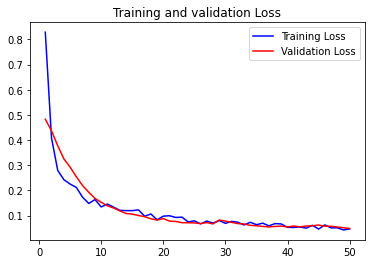

In [31]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

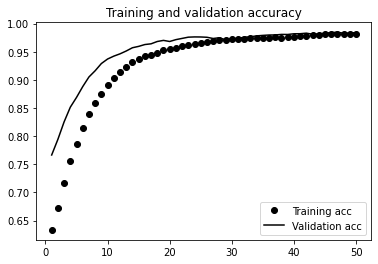

In [32]:
plt.plot(epochs, smooth_curve(acc), 'ko', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from keras.models import load_model

model = load_model("/content/drive/My Drive/TrainSets/Relatorios/August19,2020/23,49/Model")

In [33]:
model.evaluate(test_IRG, y_test)

16/16 [==============================] - 2s 105ms/step - loss: 0.0538 - accuracy: 0.9822


[0.05380462110042572, 0.9822485446929932]

In [ ]:
import time
from datetime import date

def mark_progress(model , history, acc, val_acc, loss, val_loss):

  tempo = time.strftime("%H,%M")

  hoje = date.today()
  today1 = hoje.strftime("%B %d, %Y")
  today1 = today1.replace(" ", "")

  !mkdir '/content/drive/My Drive/TrainSets/Relatorios/'{today1}
  !mkdir '/content/drive/My Drive/TrainSets/Relatorios/'{today1}'/'{tempo}


  today = [today1 for i in loss]

  epochs = range(1, len(acc)+1)

  plot = plot_model(model, to_file=f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/ModelUsed.jpg",
        show_shapes=True,
        show_layer_names=True,
        rankdir="TB",
        dpi=96,)

  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation Loss')
  plt.legend()

  plt.savefig(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Loss.jpg")
  plt.clf()

  plt.plot(epochs, acc, 'ko', label='Training acc')
  plt.plot(epochs, val_acc, 'k', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.savefig(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Validation.jpg")
  plt.clf()

  model.save(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Model")


In [ ]:
mark_progress(model, history, acc, val_acc, loss, val_loss)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/TrainSets/Relatorios/August20,2020/19,05/Model/assets


<Figure size 432x288 with 0 Axes>

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    x = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    return x

Normalized confusion matrix


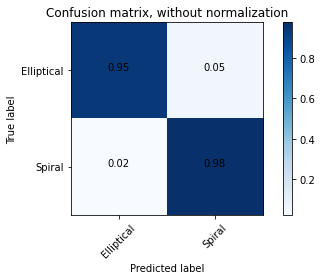

In [35]:
def get_array_labels(array):
  Label_y_pred = []
  for x in array:
    if x == 0:
      Label_y_pred = np.append(Label_y_pred,'Spiral')
    if x == 1:
      Label_y_pred = np.append(Label_y_pred,'Elliptical')

  return Label_y_pred

Y_pred = model.predict(val_IRG)

y_pred = []
for x in Y_pred: 
  if float(x[0]) > 0.50:
    y_pred.append(1)
  if float(x[0]) < 0.50:
    y_pred.append(0)

y_true = ['Elliptical',  'Spiral']


Label_y_pred = get_array_labels(y_pred)
Label_y_true = get_array_labels(val_labels)

cnf_matrix = confusion_matrix(Label_y_pred, Label_y_true, labels=y_true)

zeta = plot_confusion_matrix(cnf_matrix, classes=y_true,
                      title='Confusion matrix, without normalization', normalize=True)

report = classification_report(Label_y_true, Label_y_pred, target_names=y_true)

In [36]:
print(report)

              precision    recall  f1-score   support

  Elliptical       0.95      0.97      0.96       110
      Spiral       0.98      0.96      0.97       140

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



In [37]:
def get_uncertains(predictions):
  label_pred = []
  for objs in predictions:
    if objs >= 0.25 and objs <= 0.75:
      label_pred.append('Uncertain')
    if objs < 0.25:
      label_pred.append('Spiral')
    if objs > 0.75:
      label_pred.append('Elliptical')
    
  return label_pred

SOME OF THE RIGHT PREDICTIONS


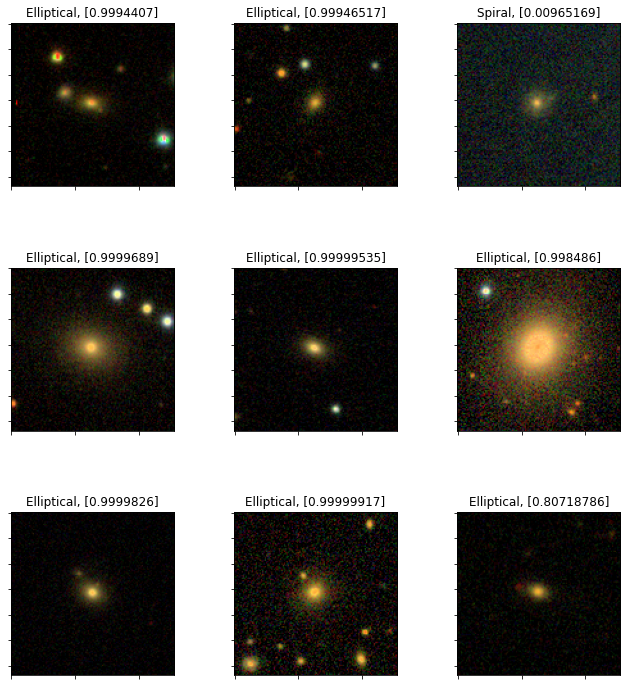

In [38]:
ellipticals = np.where(Label_y_true == 'Elliptical')
ellipticals = ellipticals[0][1:10]

ellipticals_pred = np.where(Label_y_true == 'Elliptical')
ellipticals_pred = ellipticals_pred[0][1:10]

rn_IRG = val_IRG

fig, axs = plt.subplots(3,3, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for key, value in enumerate(ellipticals_pred):
  try:
    axs[key].imshow(rn_IRG[value])
    axs[key].set_title(f'{Label_y_pred[value]}, {Y_pred[value]}' )
    axs[key].plot()

    axs[key].set_yticklabels([])
    axs[key].set_xticklabels([])
  except:
    pass

#fig.savefig('/content/drive/My Drive/TrainSets/Relatorios/August20,2020/19,05/successEllip.jpg')

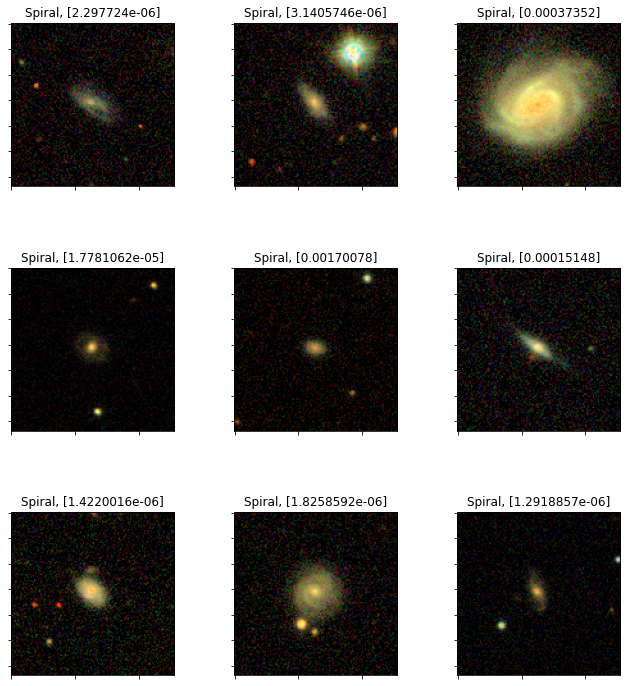

In [39]:
spirals = np.where(Label_y_true == 'Spiral')
spirals = spirals[0][0:9]

spirals_pred = np.where(Label_y_true == 'Spiral')
spirals_pred = spirals_pred[0:9]

rn_IRG = val_IRG

fig, axs = plt.subplots(3,3, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for key, value in enumerate(spirals_pred[0]):
  try:
    axs[key].imshow(rn_IRG[value])
    axs[key].set_title(f'{Label_y_pred[value]}, {Y_pred[value]}' )
    axs[key].plot()

    axs[key].set_yticklabels([])
    axs[key].set_xticklabels([])
  except:
    pass

#fig.savefig('/content/drive/My Drive/TrainSets/Relatorios/August20,2020/19,05/successSpirals.jpg')

Failures

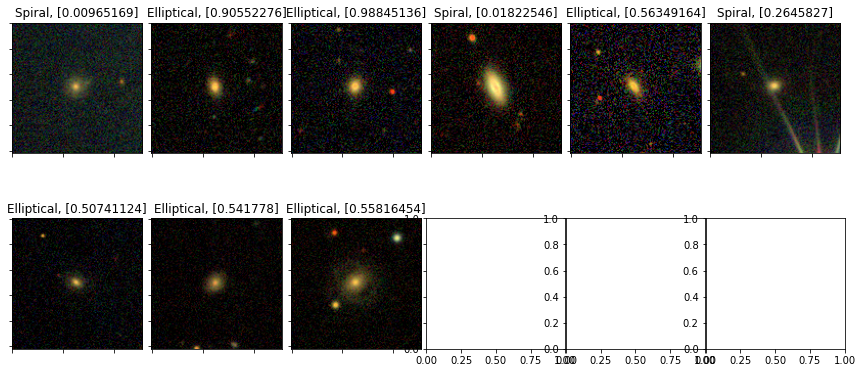

In [40]:
comparison = Label_y_pred == Label_y_true
comparison = np.where(comparison == False)
comparison[0][0]

rn_IRG = val_IRG

fig, axs = plt.subplots(2,6, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=.005)

axs = axs.ravel()
for key, value in enumerate(comparison[0]):
  try:
    axs[key].imshow(rn_IRG[value])
    axs[key].set_title(f'{Label_y_pred[value]}, {Y_pred[value]}' )
    axs[key].plot()

    axs[key].set_yticklabels([])
    axs[key].set_xticklabels([])
  except:
    pass

#fig.savefig('/content/drive/My Drive/TrainSets/Relatorios/August20,2020/19,05/Failures.jpg')

TESTING ON OBJS CONSIDERED UNCERTAINS

In [41]:
uncertain = df[df['UNCERTAIN'] == 1][10:20]

uncertain_IRG = read_spectograms(uncertain['IRG'].values, img_rows, img_cols, in_channel)
uncertain_IGU = read_spectograms(uncertain['IGU'].values, img_rows, img_cols, in_channel)
uncertain_ZRG = read_spectograms(uncertain['ZRG'].values, img_rows, img_cols, in_channel)
uncertain_R660G = read_spectograms(uncertain['R660G'].values, img_rows, img_cols, in_channel)

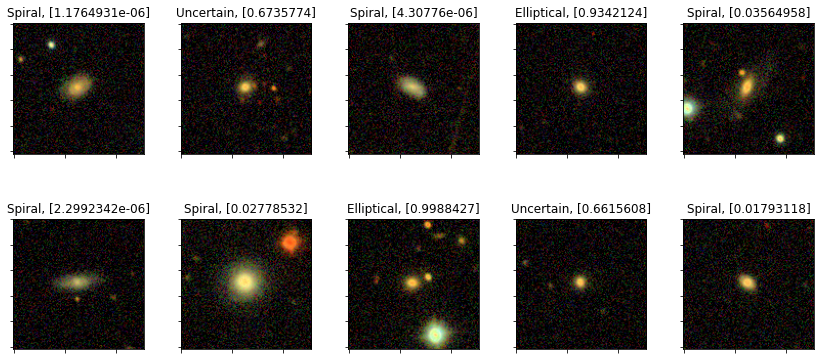

In [42]:
predictions = model.predict(uncertain_IRG)

rn_IRG = uncertain_IRG
label_pred = get_uncertains(predictions)

fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for key, value in enumerate(predictions):
  axs[key].imshow(rn_IRG[key], cmap='gray')
  axs[key].set_title(f'{label_pred[key]}, {predictions[key]}' )
  axs[key].plot()

  axs[key].set_yticklabels([])
  axs[key].set_xticklabels([])

#fig.savefig('/content/drive/My Drive/TrainSets/Relatorios/August20,2020/19,05/TestOn10Uncertain.jpg')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


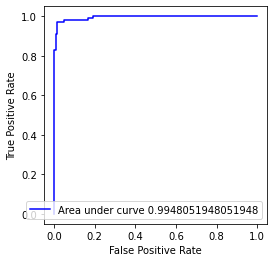

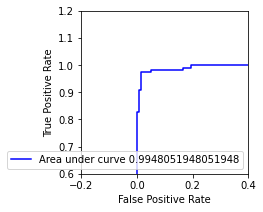

In [43]:
from sklearn.metrics import roc_curve, auc
import seaborn

plt.figure(figsize=(4,4))

fpr, tpr, thresholds = roc_curve(val_labels, Y_pred)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, 'b', label = f'Area under curve {roc_auc}')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, 'b', label = f'Area under curve {roc_auc}')
plt.legend(loc="lower right")

plt.xlim(-.2, 0.4)
plt.ylim(0.6, 1.2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

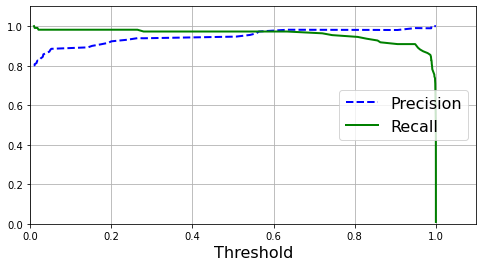

In [44]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(val_labels, Y_pred)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)   
    plt.grid(True)
    plt.axis([0, 1.1, 0, 1.1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                   
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
                      
plt.show()

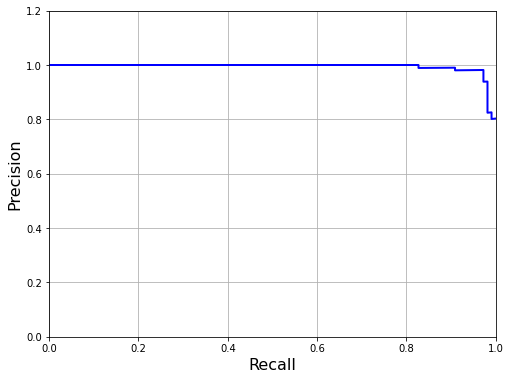

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1.2])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [46]:
SPIRALS = df.iloc[drop_indices]

SPIRALS_IRG = read_spectograms(SPIRALS['IRG'].values, img_rows, img_cols, in_channel)

In [47]:
spirals_pred = model.predict(SPIRALS_IRG)
spirals_pred1 = get_uncertains(spirals_pred)

In [48]:
new_series = pd.Series(spirals_pred1)

In [49]:
new_series.value_counts()

Spiral        1222
Uncertain       47
Elliptical      31
dtype: int64

In [50]:
y_predict = []
for x in spirals_pred: 
  if float(x[0]) > 0.50:
    y_predict.append(1)
  if float(x[0]) < 0.50:
    y_predict.append(0)

In [51]:
new_series1 = get_array_labels(y_predict)
new_series1 = pd.Series(new_series1)
new_series1.value_counts()

Spiral        1251
Elliptical      49
dtype: int64

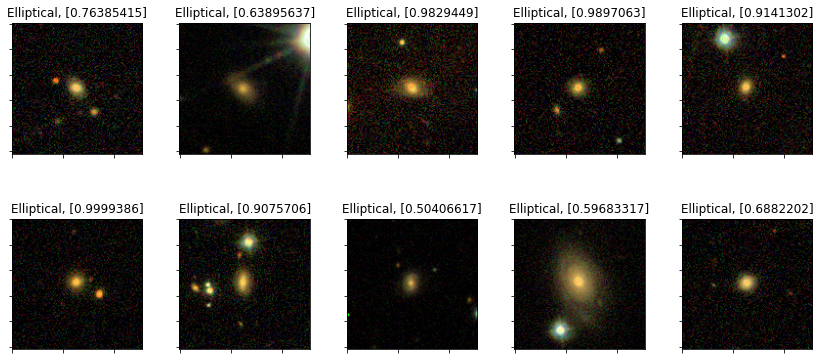

In [52]:
failures = np.where(new_series1 == 'Elliptical')
failures = failures[0]

rn_IRG = SPIRALS_IRG
label_pred = get_uncertains(y_predict)

fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for key, value in enumerate(failures):
  try:
    axs[key].imshow(rn_IRG[value], cmap='gray')
    axs[key].set_title(f'{label_pred[value]}, {spirals_pred[value]}' )
    axs[key].plot()

    axs[key].set_yticklabels([])
    axs[key].set_xticklabels([])
  except:
    pass


#fig.savefig('/content/drive/My Drive/TrainSets/Relatorios/August20,2020/19,05/FailedOn1300Spirals.jpg')

In [ ]:
Submit.make_post('gustavoschwarz', 'asdflkjh', model.to_json(), acc, val_acc, loss, val_loss, '97% Test only IRG inputs S and E', resultado, report)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


201 done
